# **APLICACIONES A CIENCIAS DE LA COMPUTACIÓN (INF265)**<br>
## **(Segundo Semestre 2023)**

# **Laboratorio 9: Algoritmos de Clasificación**

## Indicaciones generales:

- Duración: **120 minutos (2 horas)**.
- Las respuestas deben contar con **fundamento teórico**.
- Cualquier indicio de plagio resultará en la anulación de la prueba.
- Debe presentar sus respuestas en base a los resultados de ejecución en los casos que se solicite. **No se calificarán aquellas respuestas que no presenten un resultado de ejecución o que no concuerden con este**.
- Subir el cuadernillo con el nombre **lab_09_código.ipynb**, donde código es su código PUCP de 8 dígitos.

## Objetivos:
- Evaluar los diferentes algoritmos de clasificación.
- Comparar los diferentes algoritmos de clasificación.
- Analizar la definición de un modelo y mejorarlo.

# **Caso: Análisis y predicción de ataques cardíacos**

Usted recibe un dataset con la información de pacientes y ciertas características fisiológicas. Asimismo, hay pacientes que han sufrido de un ataque al corazón mientras que otros no. El propósito de este laboratorio es evaluar algoritmos de clasificación para predecir si un paciente podría llegar a sufrir un ataque al corazón con el fin de prevenirlo (**el target es la variable AHD**). El dataset cuenta con la siguiente información:


VARIABLE | DESCRIPCIÓN
--------|-------------
age | Edad del paciente
sex | Sexo del paciente: 1 for male and 0 for female
ChestPain | Tipo de dolor en el pecho (typical, asymptomatic, nonanginal, nontypical)
RestBP | Presión arterial en reposo
Chol | Cantidad de colesterol
Fbs | (Azúcar en sangre en ayunas > 120 mg/dl) (1:Sí; 0:No)
RestECG | Resultados electrocardiográficos en reposo (0: Normal, 1: Tiene anomalías, 2:Muestra hipertrofia ventricular probable)
MaxHR | Frecuencia cardiaca máxima alcanzada
ExAng | (Exercise angina) Dolor de pecho al hacer ejercicio (1:Sí, 0:No)
Oldpeak | Previo punto más alto
Slope | the slope of the peak exercise ST segment
ca | Cantidad de vasos sanguíneos colored by flourosopy
Thal | thalessemia: normal, fixed defect, reversable defect
AHD | Target: No: No sufrio de ataque al corazon: Yes: Sufrio un ataque al corazon

# **Cuestionario (20 ptos)**

1. Tratamiento de variables categoricas: Convierta las variables categóricas a numéricas (ChestPain, Thal, AHD). Escoja entre LabelEncoder y get_dummies, justificando su elección **(2 puntos)**

2. Identifique y realice tratamiento de nulos (estos aparecen como valores NA en la data). Escoja entre imputar o eliminar, justificando su elección **(2 puntos)**

3. Muestre la distribucion de las clases de la variable objetivo (AHD) e indique si hay desbalance **(2 puntos)**

4. Realizar un split train/validation con 25% para validacion

5. Evalue los siguientes algoritmos/configuraciones en estrategia de 10-fold crossvalidation en la parte de train. Como métrica de scoring use 'accuracy' **(4 puntos)**

   - LogisticRegression
   - KNeighborsClassifier( n_neighbors=5 )
   - KNeighborsClassifier( n_neighbors=10)
   - DecisionTreeClassifier(criterion="gini", max_depth=None )
   - DecisionTreeClassifier(criterion="gini", max_depth=2)
   - DecisionTreeClassifier(criterion="gini", max_depth=4)
   - DecisionTreeClassifier(criterion="entropy", max_depth=None )
   - DecisionTreeClassifier(criterion="entropy", max_depth=2)
   - DecisionTreeClassifier(criterion="entropy", max_depth=4)   

   Muestre graficamente los resultados (boxplots) en crossvalidacion de los algoritmos evaluados. De una interpretacion de los mismos en cuanto a la influencia de los hiperparámetros en cada tipo de algoritmo (n_neighbors, criterion, max_depth )

6. Con el algoritmo ganador, entrenar un modelo con todo train y predecir el target en el conjunto de validation (el 25% que separó en 4). Mostrar la Matriz de Confusion y el Reporte de Clasificacion e interprete los resultados **(3 puntos)**

7. Evalue pipelines con los mismos algoritmos definidos en 5. Escoja el paso de procesamiento que considere adecuado (MinMaxScaler, StandardScaler, PCA(n_components=x), (StandardScaler() + PCA(n_components=x)), etc.). Evalue en crossvalidacion (10 folds). ¿Qué algoritmos/configuraciones han cambiado significativamente su accuracy promedio en crosvalidacion? dé una interpretación **(4 puntos)**

8. Finalmente, Escoja el pipeline con mejor promedio de accuracy y reentrenelo con toda la data de train. Prediga el conjunto de validacion y muestre la Matriz de Confusion y el Reporte de Clasificacion e interprete los resultados.
Al final, comprare los resultados con respecto a no usar pipelines **(3 puntos)**

In [1]:
#Importar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest   # para seleccionar atributos de forma univariada (filtros)
from sklearn.feature_selection import chi2   # estadististica para evaluar la importancia de atributos en relacion al target
from sklearn.feature_selection import RFE    # metodo recursive featute elimination
from sklearn.decomposition import PCA        # para transformacion PCA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  # para modelos discriminantes lineales
from sklearn.naive_bayes import GaussianNB   # para modelos Naive Bayes
from sklearn.linear_model import LogisticRegression # para usar modelos de regresion logistica
from sklearn.tree import DecisionTreeClassifier     # para usar modelos de tipo arboles de decision
from sklearn.neighbors import KNeighborsClassifier  # para modelos  Knn
from sklearn.svm import SVC   # para modelos SVM

from sklearn.model_selection import train_test_split  # para partir los datos en conjuntos de entrenamiento y validacion
from sklearn.model_selection import KFold  # para partir la data en k-folds
from sklearn.model_selection import cross_val_score   # para evaluar algoritmos en cross validacion

from sklearn.metrics import accuracy_score, balanced_accuracy_score   # para manejar metricas de desempeño
from sklearn.metrics import classification_report  # para hacer reportes de resultados de clasificacion
from sklearn.metrics import confusion_matrix  # para manejar matrices de confusion
from sklearn.metrics import jaccard_score  # indice jacard

# carga el dataset heart
filename = 'Heart.csv'
names = ['Age','Sex','ChestPain','RestBP','Chol','Fbs','RestECG','MaxHR','ExAng','Oldpeak','Slope','Ca','Thal','AHD']
dataset = pd.read_csv(filename)

Pregunta 1:
Ya está cargado el dataset y para decidir si usaremos labelEncoder o getdummies tenemos que denotar que tipo de información contiene cada variable. Y notamos que contiene más de solo dos descripciones por ejemplo ChestPain puede ser asymptomatic, nonanginal y nontypical. Por eso decidí usar LabelEncoder ya que puede denotar esta diferencia   

In [3]:
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
dataset['AHD']=label_encoder.fit_transform(dataset['AHD'])
dataset['Thal']=label_encoder.fit_transform(dataset['Thal'])
dataset['ChestPain']=label_encoder.fit_transform(dataset['ChestPain'])

In [4]:
#Tratamiento de nulos

dataset.isnull().sum() /dataset.shape[0]

Unnamed: 0    0.000000
Age           0.000000
Sex           0.000000
ChestPain     0.000000
RestBP        0.000000
Chol          0.000000
Fbs           0.000000
RestECG       0.000000
MaxHR         0.000000
ExAng         0.000000
Oldpeak       0.000000
Slope         0.000000
Ca            0.013201
Thal          0.000000
AHD           0.000000
dtype: float64

PREGUNTA 2
Podemos ver que no existe mucha cantidad de nulos en los datos y los únicos nulos son de la variable Ca, entonces lo que se podría sería dropear solo  esas filas ya que son pocas.

In [5]:
dataset.describe()

,Unnamed: 0,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,303.000000,303.000000
mean,152.000000,54.438944,0.679868,0.841584,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,1.339934,0.458746
std,87.612784,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,0.597973,0.499120
min,1.000000,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,76.500000,48.000000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,152.000000,56.000000,1.000000,1.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,1.000000,0.000000
75%,227.500000,61.000000,1.000000,1.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,2.000000,1.000000
max,303.000000,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,3.000000,1.000000



Vamos a imputar Ca con 1 ya que vemos que la media se acerca mucho a 1

In [31]:
#Dropeamos las filas que tienen nulos ya que la media se acerca a este numero
dataset.dropna(inplace=True)

In [32]:
dataset.isnull().sum()

Age          0
Sex          0
ChestPain    0
RestBP       0
Chol         0
Fbs          0
RestECG      0
MaxHR        0
ExAng        0
Oldpeak      0
Slope        0
Ca           0
Thal         0
AHD          0
dtype: int64

In [9]:
#Dropeamos unnamed ya que es un error
dataset= dataset.drop(columns= ['Unnamed: 0'])

In [33]:
dataset.describe()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,0.841584,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.676568,1.339934,0.458746
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.931963,0.597973,0.499120
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,1.000000,0.000000
75%,61.000000,1.000000,1.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,2.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,3.000000,1.000000


In [34]:
#Mostrar la distribución de la clase AHD
print(dataset.groupby('AHD').size())

AHD
0    164
1    139
dtype: int64


PREGUNTA 3:

Notamos que existe un pequeño desbalance a favor de 0 osea "No", esto significa que es muy probable que exista un pequeño desbalance a la hora de predecir la clasificacion

In [35]:
#Realizamos un split validation de 25%

# separa el dataset en atributos (X)  y  target (y)
array = dataset.values
X = array[:,0:13]  # atributos
y = array[:,13]    # target

# realiza el train-test split
vadid_fraction = 0.25    # proporcion de muestras para validacion
seed = 7   # semilla para el generador aleatorio (para reproductibilidad)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=vadid_fraction, random_state=seed)

print('Training: %d ejemplos. Validation: %d ejemplos' % (len(y_train), len(y_valid)))

Training: 227 ejemplos. Validation: 76 ejemplos


In [36]:
#Evalue los siguientes algoritmos/configuraciones en estrategia de 10-fold crossvalidation en la parte de train. Como métrica de scoring use 'accuracy'


# Definimos el pool de algoritmos de ML a evaluar
algos = []
algos.append(('LogReg', LogisticRegression( solver='liblinear')))  #genera logistic regresors con solver liblinear
algos.append(('5NN', KNeighborsClassifier( n_neighbors=5))) #genera knn con 5 vecinos
algos.append(('10NN', KNeighborsClassifier( n_neighbors=10))) #genera knn con 5 vecinos
algos.append(('GinNone', DecisionTreeClassifier(criterion="gini", max_depth=None )))
algos.append(('Gin2', DecisionTreeClassifier(criterion="gini", max_depth=2 )))
algos.append(('Gin4', DecisionTreeClassifier(criterion="gini", max_depth=4 )))
algos.append(('EntNone', DecisionTreeClassifier(criterion="entropy", max_depth=None )))
algos.append(('Ent2', DecisionTreeClassifier(criterion="entropy", max_depth=2 )))
algos.append(('Ent4', DecisionTreeClassifier(criterion="entropy", max_depth=4 )))

# Evaluamos cada algoritmo de ML en estrategia de 10-fold-CV
results = []
names = []

# genera el particionamiento de 10 folds que seran usados en cada evaluacion
seed = 7
kfold = KFold(n_splits=10, random_state=seed, shuffle= True)  # especifica el particionador de datos a 10-folds CV

#  evalua cada algoritmo de ML
for algoname, algo in algos:
    cv_results = cross_val_score(algo, X_train, y_train, cv=kfold, scoring='balanced_accuracy')
    results.append(cv_results)
    names.append(algoname)
    print("{}: {} ({})".format(algoname, cv_results.mean(), cv_results.std()))

LogReg: 0.8459157509157509 (0.09027752934548844)
5NN: 0.5731936813186813 (0.0784097563402861)
10NN: 0.5759518259518259 (0.10787165276943039)
GinNone: 0.7245807664557664 (0.06372916711555349)
Gin2: 0.7641269841269841 (0.07647968217993696)
Gin4: 0.752571941946942 (0.05910829623591492)
EntNone: 0.7410856504606504 (0.0769405131359839)
Ent2: 0.7703769841269841 (0.0754274191271678)
Ent4: 0.7844474969474969 (0.08343276213553201)


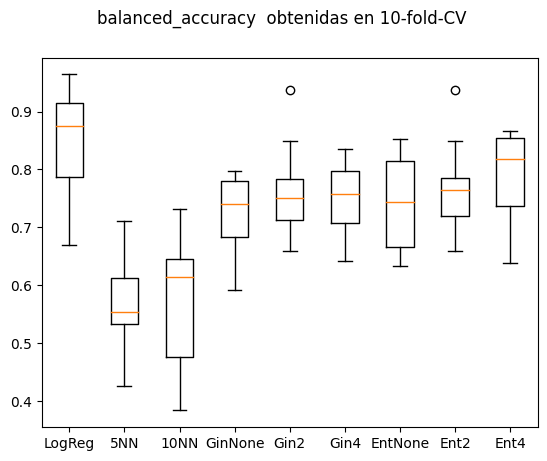

In [37]:
# Muestra graficamente los resultados de balanced_accuracy  en crossvalidacion de los Algoritmos evaluados
fig = plt.figure()
fig.suptitle('balanced_accuracy  obtenidas en 10-fold-CV')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

PREGUNTA 5:
Podemos notar del boxplot que para el caso de KNN a medida que aumento los "vecino" aumento la cantidad de variabilidad o desviacion del modelo, eso significa se hacia menos preciso. Para el caso de DecisionTree podemos notar que cuando no tiene un maximo de altura preestablecida no obtenemos mejores resultados, en compracion a cuadno establecemos una altura de 2 donde se obtiene mejores resultados, asimismo si subimos la altura llega hasta empeorar las metricas donde para gin4 o ent4 son peores que sus vecions gin2 y ent2


El algoritmo ganador es logReg ya que tiene las mejores metricas en comparación a los otros modelos

In [38]:
# Reentrena modelo LR con todos los datos de entrenamiento y lo prueba en el conjunto de validación
model = LogisticRegression(solver='liblinear', class_weight = 'balanced' ) #  usar class_weight = 'balanced') para entrenar tomando en cuenta el desbalance
model.fit(X_train, y_train)

# predice la c lase del conjunto de validacion
y_predicted = model.predict(X_valid)
print("Balanced Accuracy score:", balanced_accuracy_score(y_valid, y_predicted))

# muestra la matriz de confusion
# en la matriz de confusion, un elemento Cij es el numero de ejemplos predichos como clase j que son realmente de clase i
print("\nMatriz de Confusión:")
print(confusion_matrix(y_valid, y_predicted))

# muestra un reporte de la clasificacion en validacion
print("\nReporte de clasificacion en conjunto de validacion: \n")
print(classification_report(y_valid, y_predicted))

Balanced Accuracy score: 0.8277310924369747

Matriz de Confusión:
[[32  2]
 [12 30]]

Reporte de clasificacion en conjunto de validacion: 

              precision    recall  f1-score   support

         0.0       0.73      0.94      0.82        34
         1.0       0.94      0.71      0.81        42

    accuracy                           0.82        76
   macro avg       0.83      0.83      0.82        76
weighted avg       0.84      0.82      0.82        76



PREGUNTA 6:
Podemos notar que usando este modelo de entrenamiento para predecir una clasificación obtenemos resultados considerables ya que acierta un 80% de las veces. Notamos también el hecho que contenga una considerable cantidad de falsos negativos en comparación con la cantidad de falsos positivos, esto nos indica que si queremos mejorar este algoritmo de clasificación se debería brindar mayor cantidad de datos para entrenar donde el AHD sea positivo, esto se puede explicar por el desbalance anteriormente mencionado en la clase AHD

In [39]:
#Ahora vamos a evauar los pipelines
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.pipeline import make_pipeline


# Definimos el pool de pipleines de ML (MinMaxScaler + algoritmo de ML) a evaluar
pipelines = []
pipelines.append(('LogReg', make_pipeline(MinMaxScaler(),LogisticRegression(solver='liblinear'))))
pipelines.append(('5NN', make_pipeline(MinMaxScaler(), KNeighborsClassifier(n_neighbors=5))))
pipelines.append(('10NN', make_pipeline(MinMaxScaler(), KNeighborsClassifier(n_neighbors=10))))
pipelines.append(('GinNone',make_pipeline(MinMaxScaler(), DecisionTreeClassifier(criterion="gini", max_depth=None ))))
pipelines.append(('Gin2', make_pipeline(MinMaxScaler(),DecisionTreeClassifier(criterion="gini", max_depth=2 ))) )
pipelines.append(('Gin4', make_pipeline(MinMaxScaler(),DecisionTreeClassifier(criterion="gini", max_depth=4 ))) )
pipelines.append(('EntNone',make_pipeline(MinMaxScaler(), DecisionTreeClassifier(criterion="entropy", max_depth=None ))))
pipelines.append(('Ent2', make_pipeline(MinMaxScaler(),DecisionTreeClassifier(criterion="entropy", max_depth=2 ))) )
pipelines.append(('Ent4', make_pipeline(MinMaxScaler(),DecisionTreeClassifier(criterion="entropy", max_depth=4 ))) )

In [40]:
results = []
names = []

# genera el particionamiento de 10 folds que seran usados en cada evaluacion
seed = 7
kfold = KFold(n_splits=10, random_state=seed, shuffle= True)  # especifica el particionador de datos a 10-folds CV

#  evalua cada pipeline en crosvalidacion
for pipelinename, pipeline in pipelines:
    cv_results = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='balanced_accuracy')
    results.append(cv_results)
    names.append(pipelinename)
    print("{}: {} ({})".format(pipelinename, cv_results.mean(), cv_results.std()))

LogReg: 0.8421657509157509 (0.08827672797607206)
5NN: 0.7958246614496615 (0.10936441486075389)
10NN: 0.7653385503385504 (0.05603931452976527)
GinNone: 0.7158605283605285 (0.05170478882382725)
Gin2: 0.7641269841269841 (0.07647968217993696)
Gin4: 0.7450719419469418 (0.06849377775312572)
EntNone: 0.7455728299478299 (0.06459360937285227)
Ent2: 0.7703769841269841 (0.0754274191271678)
Ent4: 0.7913522588522589 (0.08178149805886346)


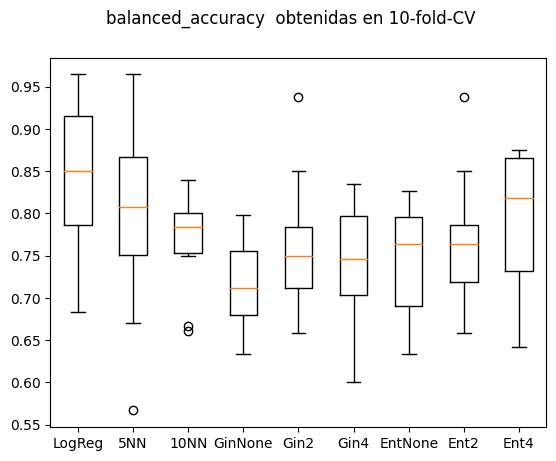

In [41]:
fig = plt.figure()
fig.suptitle('balanced_accuracy  obtenidas en 10-fold-CV')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

PREGUNTA 7:
Notamos que los algoritmos sobre todo de KNN mejoraron en gran medida sus metricas, hasat casi acercandose al mejor modelo. Especificamente el KNN de 5 vecinos paso de 0.573193 a 0.79582,una gran diferencia, esto es debido al pipeline ya que esto ayuda a este tipo de algoritmos

In [42]:
# Reentrena el pipeline LR con todos los datos de entrenamiento y lo prueba en el conjunto de validación
model = make_pipeline(MinMaxScaler(), LogisticRegression(solver='liblinear',  class_weight = 'balanced')) #  usar class_weight = 'balanced') para entrenar tomando en cuenta el desbalance
model.fit(X_train, y_train)

# predice la c lase del conjunto de validacion
y_predicted = model.predict(X_valid)
print("Balanced Accuracy score:", balanced_accuracy_score(y_valid, y_predicted))

# muestra la matriz de confusion
# en la matriz de confusion, un elemento Cij es el numero de ejemplos predichos como clase j que son realmente de clase i
print("\nMatriz de Confusión:")
print(confusion_matrix(y_valid, y_predicted))

# muestra un reporte de la clasificacion en validacion
print("\nReporte de clasificacion en conjunto de validacion:\n")
print(classification_report(y_valid, y_predicted))

Balanced Accuracy score: 0.8368347338935573

Matriz de Confusión:
[[31  3]
 [10 32]]

Reporte de clasificacion en conjunto de validacion:

              precision    recall  f1-score   support

         0.0       0.76      0.91      0.83        34
         1.0       0.91      0.76      0.83        42

    accuracy                           0.83        76
   macro avg       0.84      0.84      0.83        76
weighted avg       0.84      0.83      0.83        76



PREGUNTA 8:
Notamos que ahora ha mejorado las predicciones de datos, conteniendo una mejor precisión y a su vez bajando los falsos positivos, per incremento en 1 los falsos negativos. Notandose así que existe una mayor balance en esta predicción cuando se usa pipelines y no añadiendo más datos.